In [57]:
import pandas as pd
import numpy as np

data = pd.DataFrame(pd.read_csv("heart_2022_no_nans.csv"))

In [58]:
data = data.drop(columns=["State", "RaceEthnicityCategory"])
data = data.replace("Female", "0")
data = data.replace("Male", "1")
data["AgeCategory"] = data["AgeCategory"].str[4:6]

data["GeneralHealth"] = data["GeneralHealth"].replace({"Poor":"0", "Fair":"1", "Good":"2", "Very good":"3", "Excellent":"4"})
data["LastCheckupTime"] = data["LastCheckupTime"].replace({"Within past year (anytime less than 12 months ago)":"0",
                                                           "Within past 2 years (1 year but less than 2 years ago)": "1",
                                                          "Within past 5 years (2 years but less than 5 years ago)": "2",
                                                          "5 or more years ago": "3"})

data["RemovedTeeth"] = data["RemovedTeeth"].replace({"All": "3", 
                                                     "6 or more, but not all": "2",
                                                     "1 to 5": "1",
                                                     "None of them": "0"
                                                    })


data["HadDiabetes"] = data["HadDiabetes"].replace({"No":"0",
                                                  "No, pre-diabetes or borderline diabetes": "1",
                                                  "Yes, but only during pregnancy (female)": "2",
                                                  "Yes": "3"})

data["SmokerStatus"] = data["SmokerStatus"].replace({"Never smoked": "0",
                                                    "Former smoker": "1",
                                                    "Current smoker - now smokes some days": "2",
                                                    "Current smoker - now smokes every day": "3"})

data["ECigaretteUsage"] = data["ECigaretteUsage"].replace({"Never used e-cigarettes in my entire life": "0",
                                                          "Not at all (right now)": "1",
                                                          "Use them some days": "2",
                                                          "Use them every day":"3"})

data["TetanusLast10Tdap"] = data["TetanusLast10Tdap"].replace({"No, did not receive any tetanus shot in the past 10 years": "0",
                                                              "Yes, received tetanus shot but not sure what type": "1",
                                                              "Yes, received tetanus shot, but not Tdap": "2",
                                                              "Yes, received Tdap": "3"})
data["CovidPos"] = data["CovidPos"].replace({"No":"0", 
                                             "Tested positive using home test without a health professional": "1",
                                             "Yes": "2"})

data = data.replace({"No":"0",
                     "Yes": "1"})

data.head()

,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,HadAngina,...,HeightInMeters,WeightInKilograms,BMI,AlcoholDrinkers,HIVTesting,FluVaxLast12,PneumoVaxEver,TetanusLast10Tdap,HighRiskLastYear,CovidPos
0,0,3,4.0,0.0,0,1,9.0,0,0,0,...,1.60,71.67,27.99,0,0,1,1,3,0,0
1,1,3,0.0,0.0,0,1,6.0,0,0,0,...,1.78,95.25,30.13,0,0,1,1,1,0,0
2,1,3,0.0,0.0,0,0,8.0,2,0,0,...,1.85,108.86,31.66,1,0,0,1,0,0,2
3,0,1,5.0,0.0,0,1,9.0,0,0,0,...,1.70,90.72,31.32,0,0,1,1,0,0,2
4,0,2,3.0,15.0,0,1,5.0,1,0,0,...,1.55,79.38,33.07,0,0,1,1,0,0,0


In [59]:
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


le = LabelEncoder()
data1 = data.copy(deep = True)


col = list(data.columns)
categorical_features = []
numerical_features = []
for i in data1.columns:
    if len(data[i].unique()) > 6:
        numerical_features.append(i)
    else:
        data1[i] = le.fit_transform(data1[i])
        categorical_features.append(i)

In [60]:
X = data1.drop(['HadHeartAttack'], axis=1)
y = data1['HadHeartAttack']
scaler = StandardScaler()

### Функція валідації моделі

Модель випробовується на початкових даних, працює як для моделі логістичної регресії, так і для моделі дерева рішень.

In [62]:
all_logreg_logs = pd.DataFrame()
all_dtree_logs = pd.DataFrame()

def validate_model(model, model_scaler, balancing_method_name: str):        
    global all_logreg_logs, all_dtree_logs, X, y
    
    X_initial_scaled = model_scaler.transform(X)
    
    if isinstance(model, LogisticRegression):
        weights = model.coef_[0]
        intercept = model.intercept_[0]
        
        logits = np.dot(X_initial_scaled, weights) + intercept
        probabilities = 1 / (1 + np.exp(-logits))
        y_pred_initial = (probabilities >= 0.5).astype(int)
    else:
        probabilities = model.predict_proba(X_initial_scaled)[:, 1]
        y_pred_initial = model.predict(X_initial_scaled)
    
    accuracy_initial = accuracy_score(y, y_pred_initial)
    precision_initial = precision_score(y, y_pred_initial)
    recall_initial = recall_score(y, y_pred_initial)
    f1_initial = f1_score(y, y_pred_initial)
    roc_auc_initial = roc_auc_score(y, probabilities)
    initial_validation_log = pd.DataFrame(data=[accuracy_initial,
                                                precision_initial,
                                                recall_initial,
                                                f1_initial,
                                                roc_auc_initial],
                                          index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                                          columns=[f"{balancing_method_name}"])
    
    if isinstance(model, LogisticRegression):
        all_logreg_logs = pd.concat([all_logreg_logs, initial_validation_log], axis=1)
        print("\nLogistic Regression")
        print(all_logreg_logs.transpose())
    else:
        all_dtree_logs = pd.concat([all_dtree_logs, initial_validation_log], axis=1)
        print("\nDecision Tree")
        print(all_dtree_logs.transpose())

### Функції тренування моделей

Відбувається почергове тренування спочатку моделі логістичної регресії, а після й моделі дерева рішень. Після тренування кожної моделі виводиться лог точності моделі по **збалансованим даним**. Після ввідбувається валідація кожної моделі та заноситься у загальний лог по всім методам та моделям.

In [63]:
def train_models(X_balanced, y_balanced, balancing_method_name: str):
    global scaler
    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.35, random_state=0)
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    logreg_model = train_regression_model(X_train_scaled, X_test_scaled, y_train, y_test)
    
    dtree_model = train_dtree_model(X_train_scaled, X_test_scaled, y_train, y_test)

    print("\n\nComparison After Validation")
    validate_model(logreg_model, scaler, balancing_method_name)
    validate_model(dtree_model, scaler, balancing_method_name)

In [64]:
def train_regression_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    logreg = LogisticRegression(solver="liblinear", penalty="l2", C=0.00001, max_iter=10000)
    logreg.fit(X_train_balanced, y_train_balanced)
    y_pred_log = logreg.predict(X_test_balanced)
    
    y_pred_proba_log = logreg.predict_proba(X_test_balanced)
    fpr_log, tpr_log, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_log[:,1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_log),
                             precision_score(y_test_balanced, y_pred_log, average='binary'),
                             recall_score(y_test_balanced, y_pred_log, average='binary'),
                             f1_score(y_test_balanced, y_pred_log, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_log[:,1])],
                       index=['Accuracy','Precision','Recall','F1-score','AUC'],
                       columns=["Logistic Regression"])
    print(log)
    return logreg

In [65]:
def train_dtree_model(X_train_balanced, X_test_balanced, y_train_balanced, y_test_balanced):
    dtree = DecisionTreeClassifier(random_state=0)
    dtree.fit(X_train_balanced, y_train_balanced)
    y_pred_tree = dtree.predict(X_test_balanced)
    
    y_pred_proba_tree = dtree.predict_proba(X_test_balanced)
    fpr_tree, tpr_tree, _ = metrics.roc_curve(y_test_balanced, y_pred_proba_tree[:, 1])
    
    log = pd.DataFrame(data=[accuracy_score(y_test_balanced, y_pred_tree),
                             precision_score(y_test_balanced, y_pred_tree, average='binary'),
                             recall_score(y_test_balanced, y_pred_tree, average='binary'),
                             f1_score(y_test_balanced, y_pred_tree, average='binary'),
                             roc_auc_score(y_test_balanced, y_pred_proba_tree[:, 1])],
                       index=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC'],
                       columns=["Decision Tree"])
    print(log)
    return dtree

### Without Sampling

Перевірка точності моделі без балансування класів. Так ми зможемо зрозуміти яЯкщо модель після балансування класів буде менш точною.

In [66]:
train_models(X, y, "Without_Sampling")

           Logistic Regression
Accuracy              0.945266
Precision             0.497637
Recall                0.358740
F1-score              0.416924
AUC                   0.886588
           Decision Tree
Accuracy        0.914352
Precision       0.255478
Recall          0.297850
F1-score        0.275042
AUC             0.623877


Comparison After Validation

Logistic Regression
                  Accuracy  Precision    Recall  F1-score      AUC
Without_Sampling  0.944692   0.491283  0.360774  0.416034  0.88379

Decision Tree
                  Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling  0.970019    0.71315  0.754447  0.733218  0.868494


## Oversampling

Усього було перевірено 5 методів: Random Oversampling, SMOTE, ADASYN, K-means SMOTE, BorderLineSMOTE

### Random Oversampling

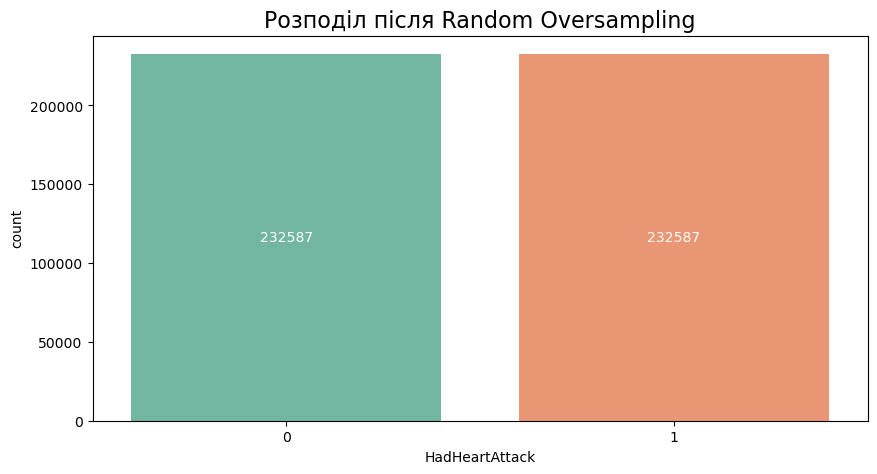

In [10]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')

X_ROS, y_ROS = oversample.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_ROS, hue=y_ROS, legend=False, palette="Set2")
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після Random Oversampling", size=16)    
plt.show()

In [11]:
train_models(X_ROS, y_ROS, "Random_Oversampling")

           Logistic Regression
Accuracy              0.792741
Precision             0.803844
Recall                0.772887
F1-score              0.788062
AUC                   0.876059
           Decision Tree
Accuracy        0.970825
Precision       0.944717
Recall          1.000000
F1-score        0.971573
AUC             0.970909


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score      AUC
Without_Sampling     0.944692   0.491283  0.360774  0.416034  0.88379
Random_Oversampling  0.810346   0.192689  0.775288  0.308663  0.87663

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.970019   0.713150  0.754447  0.733218  0.868494
Random_Oversampling  0.980693   0.738796  1.000000  0.849779  0.989789


### SMOTE

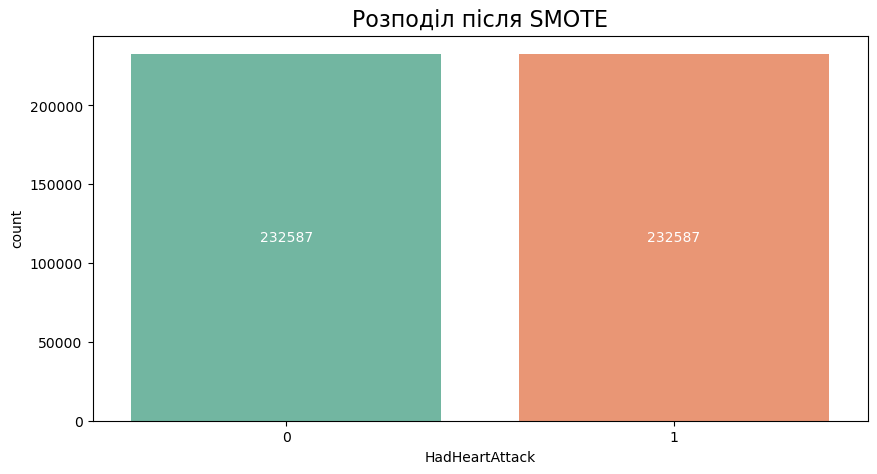

In [12]:
from  imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
import threadpoolctl

# Налаштування багатопоточності
with threadpoolctl.threadpool_limits(limits=4, user_api='blas'):
    smote = SMOTE(sampling_strategy='auto', random_state=0, k_neighbors=NearestNeighbors(n_jobs=-1))
    X_smote, y_smote = smote.fit_resample(X, y)

plt.figure(figsize=(10, 5))
ax = sns.countplot(x=y_smote, hue=y_smote, palette="Set2", legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після SMOTE", size=16)
plt.show()

In [13]:
train_models(X_smote, y_smote, "SMOTE")

           Logistic Regression
Accuracy              0.828605
Precision             0.821019
Recall                0.839154
F1-score              0.829988
AUC                   0.907296
           Decision Tree
Accuracy        0.918531
Precision       0.903358
Recall          0.936812
F1-score        0.919781
AUC             0.918584


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.944692   0.491283  0.360774  0.416034  0.883790
Random_Oversampling  0.810346   0.192689  0.775288  0.308663  0.876630
SMOTE                0.807070   0.164755  0.622404  0.260543  0.802139

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.970019   0.713150  0.754447  0.733218  0.868494
Random_Oversampling  0.980693   0.738796  1.000000  0.849779  0.989789
SMOTE                0.956488   0.571842  0.808709  0.669955  0.886866


### ADASYN

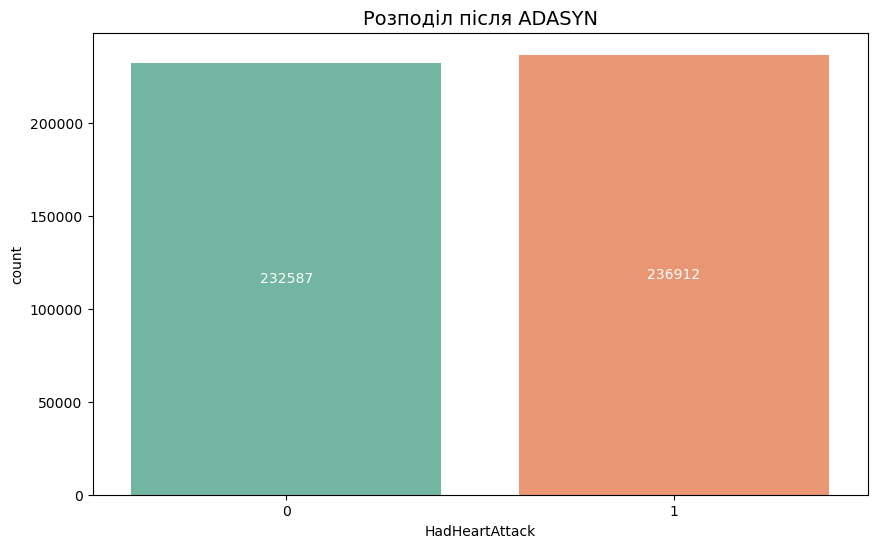

In [14]:
from  imblearn.over_sampling import ADASYN 

adasyn  = ADASYN(n_neighbors=NearestNeighbors(n_jobs=-1), random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)


plt.figure(figsize = (10,6))
ax=sns.countplot( x = y_adasyn, hue=y_adasyn, palette="Set2", legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після ADASYN", size=14)
plt.show()

In [15]:
train_models(X_adasyn, y_adasyn, "ADASYN")

           Logistic Regression
Accuracy              0.827014
Precision             0.820534
Recall                0.840153
F1-score              0.830228
AUC                   0.905391
           Decision Tree
Accuracy        0.920310
Precision       0.906769
Recall          0.938172
F1-score        0.922203
AUC             0.920186


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.944692   0.491283  0.360774  0.416034  0.883790
Random_Oversampling  0.810346   0.192689  0.775288  0.308663  0.876630
SMOTE                0.807070   0.164755  0.622404  0.260543  0.802139
ADASYN               0.802522   0.160848  0.620394  0.255463  0.796691

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.970019   0.713150  0.754447  0.733218  0.868494
Random_Oversampling  0.980693   0.738796  1.000000  0.849779  0.989789
SMOTE                0.956488 

### K-means SMOTE

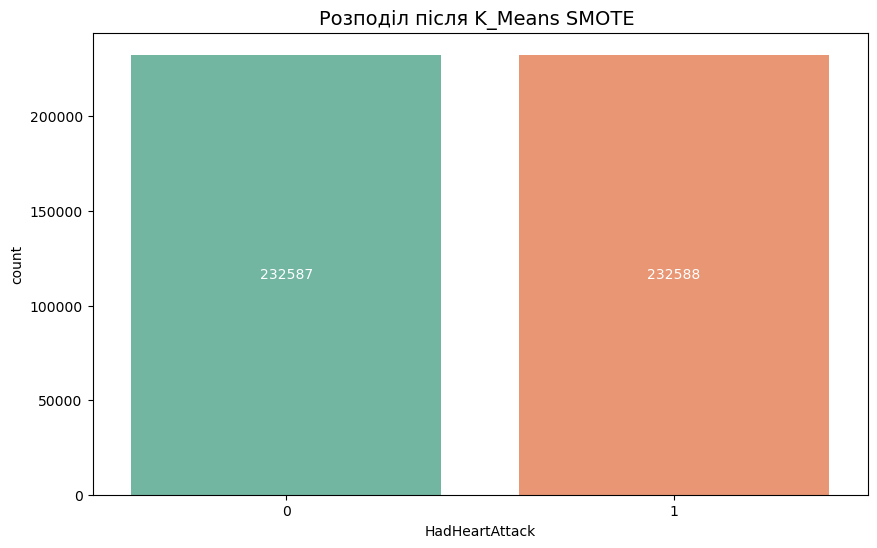

In [16]:
from  imblearn.over_sampling import KMeansSMOTE

KSMOTE  = KMeansSMOTE(cluster_balance_threshold=0.1)
X_KSMOTE, y_KSMOTE = KSMOTE.fit_resample(X, y)


plt.figure(figsize = (10,6))
ax=sns.countplot( x = y_KSMOTE, hue=y_KSMOTE, palette="Set2", legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після K_Means SMOTE ", size=14)
plt.show()

In [17]:
train_models(X_KSMOTE, y_KSMOTE, "K-means SMOTE")

           Logistic Regression
Accuracy              0.927794
Precision             0.914463
Recall                0.943416
F1-score              0.928714
AUC                   0.972760
           Decision Tree
Accuracy        0.950176
Precision       0.943756
Recall          0.957103
F1-score        0.950383
AUC             0.950196


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.944692   0.491283  0.360774  0.416034  0.883790
Random_Oversampling  0.810346   0.192689  0.775288  0.308663  0.876630
SMOTE                0.807070   0.164755  0.622404  0.260543  0.802139
ADASYN               0.802522   0.160848  0.620394  0.255463  0.796691
K-means SMOTE        0.884055   0.206169  0.394045  0.270703  0.803609

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.970019   0.713150  0.754447  0.733218  0.868494
Random_Oversampling  0.980693 

### Border SMOTE

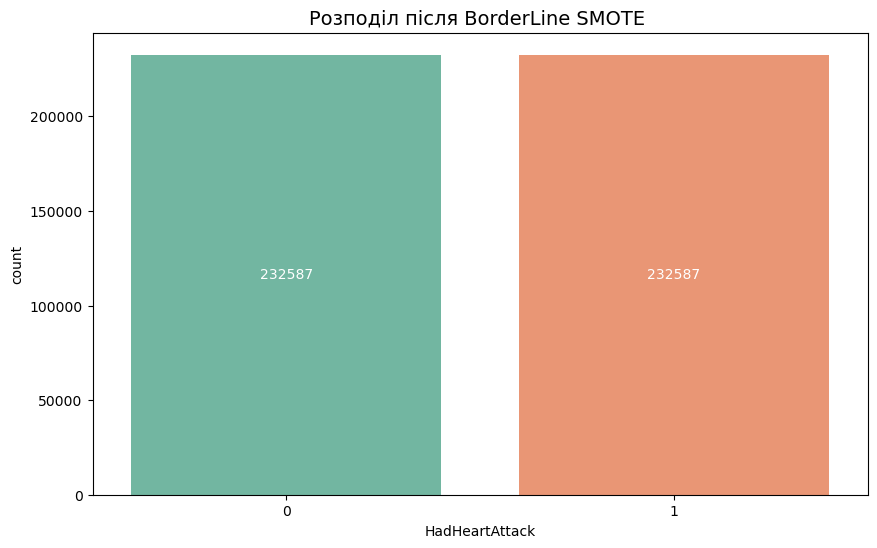

In [20]:
from imblearn.over_sampling import BorderlineSMOTE


borderline_smote = BorderlineSMOTE(sampling_strategy='auto', random_state=0)
X_BSMOTE, y_BSMOTE = borderline_smote.fit_resample(X, y)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x=y_BSMOTE, hue=y_BSMOTE, palette="Set2", legend=False)
for container in ax.containers:
    ax.bar_label(container, label_type='center', rotation=0, color='white')
plt.title("Розподіл після BorderLine SMOTE ", size=14)
plt.show()

In [21]:
train_models(X_BSMOTE, y_BSMOTE, "BorderLine SMOTE")

           Logistic Regression
Accuracy              0.856152
Precision             0.841807
Recall                0.876113
F1-score              0.858618
AUC                   0.930669
           Decision Tree
Accuracy        0.928752
Precision       0.915751
Recall          0.943933
F1-score        0.929629
AUC             0.928795


Comparison After Validation

Logistic Regression
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.944692   0.491283  0.360774  0.416034  0.883790
Random_Oversampling  0.810346   0.192689  0.775288  0.308663  0.876630
SMOTE                0.807070   0.164755  0.622404  0.260543  0.802139
ADASYN               0.802522   0.160848  0.620394  0.255463  0.796691
K-means SMOTE        0.884055   0.206169  0.394045  0.270703  0.803609
BorderLine SMOTE     0.824788   0.181771  0.630741  0.282213  0.821922

Decision Tree
                     Accuracy  Precision    Recall  F1-score       AUC
Without_Sampling     0.970019 

### Висновок

Можна бачити, що при тестуванні на збалансованих даних моделі **SMOTE, ADASYN, K-means SMOTE, BorderLineSMOTE** виправно показують високу точність. Але у таблиці результатів після валідації (тестуванні на початкових даних) можна бачити що кожен з цих методів балансування має точність нижчу, ніж модель без балансування. 

Лише у випадку з **Random Oversampling** можна побачити збільшення точності моделі на початкових даних, тобто лише цей метод дозволяє отримати гарно узагальнюючу модель. Причому лише для дерева рішень. Я припускаю що це пов'язано з тим, що це єдиний метод балансування, з використаних, що не створює синтетичних даних, а лише копіює існуючі. 

Тренувальний набір даних має близько 40 змінних та дизбаланс 9 до 1, через що такі методи як **SMOTE** чи **ADASY** можуть створювати нереалістичні записи.

Витягнути таблицю результатів методів після валідації на початкових даних:

In [18]:
with pd.ExcelWriter('output.xlsx') as writer:
    all_logreg_logs.transpose().to_excel(writer, sheet_name='LogisticRegression', index=False)
    all_dtree_logs.transpose().to_excel(writer, sheet_name='DecisionTree', index=False)

print("Excel файл успішно створено")

Excel файл успішно створено!
